## Graph Parser

### Relationship Graph Parser

In [1]:
import re
import spacy
import networkx as nx
import matplotlib.pyplot as plt

class RelationshipGraphParser:
    """
    A syntactic (non-causal) relationship parser that converts a sentence/question
    into a directed graph of lightweight triples (head, rel, tail), where
    rel ∈ {subj, obj, isa, prep_*}. Designed as a class to mirror the causal parser.
    """

    def __init__(self, model_name: str = "en_core_web_sm"):
        try:
            self.nlp = spacy.load(model_name)
        except OSError:
            print(f"Please install spaCy English model: python -m spacy download {model_name}")
            raise

        self.SUBJ_DEPS = {"nsubj", "nsubjpass", "csubj", "csubjpass"}
        self.OBJ_DEPS  = {"dobj", "obj", "attr", "oprd", "dative"}
        self.NEG_DEPS  = {"neg"}

    # ---------------- node labeling helpers ----------------
    def noun_phrase_label(self, head, include_det: bool = False, use_ents: bool = True) -> str:
        # 1) prefer named entities (incl. FAC)
        if use_ents:
            for ent in head.doc.ents:
                if ent.start <= head.i < ent.end and ent.label_ in {
                    "PERSON","ORG","GPE","LOC","PRODUCT","EVENT","WORK_OF_ART","FAC"
                }:
                    return ent.text

        # 2) noun_chunk (optionally drop determiners)
        chunk = next((nc for nc in head.doc.noun_chunks if nc.root == head), None)
        if chunk is not None:
            toks = [t for t in chunk if include_det or t.dep_ != "det"]
            return " ".join(t.text for t in toks).strip()

        # 3) fallback: compounds/adjectives/numerals + head (+ "of"-PP)
        keep = {"amod", "compound", "nummod", "poss"}
        left = []
        for c in sorted([c for c in head.lefts if c.dep_ in keep], key=lambda x: x.i):
            left.append(c.text if c.dep_ != "poss" else c.text + "'s")
        label = " ".join(left + [head.text]).strip()
        for prep in (c for c in head.children if c.dep_ == "prep" and c.text.lower() == "of"):
            for p in (c for c in prep.children if c.dep_ == "pobj"):
                label += " of " + self.noun_phrase_label(p, include_det=include_det)
        return label

    def verb_label(self, tok):
        base = tok.lemma_
        prt  = [c.text for c in tok.children if c.dep_ == "prt"]
        return " ".join([base] + prt)

    def collect_neg(self, tok):
        return any(c.dep_ in self.NEG_DEPS for c in tok.children)

    def has_copula(self, tok):
        return any(c.dep_ == "cop" for c in tok.children)

    def is_passive_auxiliary(self, tok):
        """AUX 'be' that carries a passive subject child."""
        return (tok.pos_ == "AUX" and tok.lemma_ == "be" and
                any(c.dep_ in {"nsubjpass", "csubjpass"} for c in tok.children))

    def find_main_verb_in_passive(self, aux_tok):
        """Find the past participle governed by the passive auxiliary."""
        # direct child VBN
        for child in aux_tok.children:
            if child.pos_ == "VERB" and child.tag_ == "VBN":
                return child
        # fallback: look ahead for a VBN whose head is aux
        for tok in aux_tok.doc:
            if (tok.i > aux_tok.i and tok.pos_ == "VERB" and
                tok.tag_ == "VBN" and tok.head == aux_tok):
                return tok
        return None

    # ---------------- robust subject finder ----------------
    def subjects_for(self, pred):
        # 1) direct dep
        subs = [c for c in pred.children if c.dep_ in self.SUBJ_DEPS]
        if subs:
            return subs

        # 2) borrow from coordinated predicate
        if pred.dep_ == "conj" and pred.head.pos_ in {"VERB","ADJ","NOUN"}:
            sh = [c for c in pred.head.children if c.dep_ in self.SUBJ_DEPS]
            if sh:
                return sh

        # 3) if predicate is VERB but passive subject is attached to an AUX
        if pred.pos_ == "VERB":
            for tok in pred.doc:
                if tok.pos_ == "AUX" and tok.lemma_ == "be" and any(c.dep_ in self.SUBJ_DEPS for c in tok.children):
                    return [c for c in tok.children if c.dep_ in self.SUBJ_DEPS]

        # 4) aux-fronted question: noun_chunks between last AUX and predicate
        aux_before = [t for t in pred.doc if t.i < pred.i and t.pos_ == "AUX"]
        if aux_before:
            left_idx = max(a.i for a in aux_before)
            chunks = [nc for nc in pred.doc.noun_chunks if left_idx < nc.end <= pred.i]
            if chunks:
                return [sorted(chunks, key=lambda nc: nc.end)[-1].root]

        # 5) general fallback: rightmost noun_chunk before predicate
        chunks = [nc for nc in pred.doc.noun_chunks if nc.end <= pred.i]
        if chunks:
            return [sorted(chunks, key=lambda nc: nc.end)[-1].root]

        # 6) token fallback
        cands = [t for t in pred.doc if t.i < pred.i and t.pos_ in {"NOUN","PROPN","PRON"}]
        if cands:
            return [cands[-1]]

        return []

    # ---------------- core extraction ----------------
    def sentence_relations(self, sentence: str, include_det: bool = False):
        doc = self.nlp(sentence)
        triples_set = set()

        processed_aux = set()  # to avoid double-processing passives

        # ---- Special pattern: be + ADJ (+ prep ...) like "Is X visible from Y?"
        if (len(doc) >= 2 and
            any(t.pos_ == "AUX" and t.lemma_ == "be" for t in doc) and
            any(t.pos_ == "ADJ" and t.dep_ in {"acomp","attr"} for t in doc)):
            adj = next((t for t in doc if t.pos_ == "ADJ" and t.dep_ in {"acomp","attr"}), None)
            subj_tok = next((t for t in doc if t.dep_ in self.SUBJ_DEPS), None)
            if adj and subj_tok:
                subj_text = self.noun_phrase_label(subj_tok, include_det)
                adj_text  = adj.lemma_
                # attach preps to adjective anchor as properties
                attached = False
                for prep in (c for c in adj.children if c.dep_ == "prep"):
                    pobj = next((c for c in prep.children if c.dep_ == "pobj"), None)
                    if pobj:
                        loc_text = self.noun_phrase_label(pobj, include_det)
                        triples_set.add((subj_text, "property", f"{adj_text} {prep.text} {loc_text}"))
                        attached = True
                if not attached:
                    triples_set.add((subj_text, "property", adj_text))

        # ---- General pass: iterate tokens and apply cases
        for tok in doc:
            # Case F: AUX as ROOT for "Is X Y?" → (X, isa, Y)
            if tok.i == tok.head.i and tok.pos_ == "AUX" and tok.lemma_ == "be":
                subjects = [c for c in tok.children if c.dep_ in self.SUBJ_DEPS]
                attrs    = [c for c in tok.children if c.dep_ in {"attr", "acomp"}]
                if subjects and attrs:
                    subj = self.noun_phrase_label(subjects[0], include_det)
                    pred = self.noun_phrase_label(attrs[0], include_det) if attrs[0].pos_ != "ADJ" else attrs[0].lemma_
                    triples_set.add((subj, "isa", pred))

            # Case A: Passive voice handled from AUX ("be" + VBN)
            if tok.pos_ == "AUX" and self.is_passive_auxiliary(tok) and tok.i not in processed_aux:
                main_verb = self.find_main_verb_in_passive(tok)
                if main_verb:
                    processed_aux.add(tok.i)
                    v = self.verb_label(main_verb)
                    if self.collect_neg(tok) or self.collect_neg(main_verb):
                        v = f"not {v}"

                    # passive subjects on AUX
                    subs = [c for c in tok.children if c.dep_ in self.SUBJ_DEPS]
                    for s in subs:
                        subj = self.noun_phrase_label(s if s.pos_ in {"NOUN","PROPN"} else s.head, include_det)
                        triples_set.add((subj, "subj", v))

                    # prepositional phrases on main verb
                    for prep in (c for c in main_verb.children if c.dep_ == "prep"):
                        for p in (c for c in prep.children if c.dep_ == "pobj"):
                            tail = self.noun_phrase_label(p, include_det) if p.pos_ in {"NOUN","PROPN"} else p.text
                            triples_set.add((v, f"prep_{prep.text.lower()}", tail))
                continue  # don't double-handle this AUX

            # Case B: Regular VERB predicates (skip passive participles already handled)
            if tok.pos_ == "VERB" and tok.i not in processed_aux:
                # skip if this VBN is governed by a passive AUX we already processed
                governed_by_passive_aux = False
                for aux in tok.doc:
                    if aux.pos_ == "AUX" and aux.lemma_ == "be" and self.find_main_verb_in_passive(aux) == tok:
                        governed_by_passive_aux = True
                        break
                if governed_by_passive_aux:
                    continue

                # skip support-verb "do/does/did" that just supports another verb
                if tok.lemma_ == "do" and any(c.pos_ == "VERB" for c in tok.children):
                    continue

                v = self.verb_label(tok)
                if self.collect_neg(tok):
                    v = f"not {v}"

                # subjects
                subs = self.subjects_for(tok)
                for s in subs:
                    subj = self.noun_phrase_label(s if s.pos_ in {"NOUN","PROPN"} else s.head, include_det)
                    triples_set.add((subj, "subj", v))

                # objects
                for o in (c for c in tok.children if c.dep_ in self.OBJ_DEPS):
                    tail = self.noun_phrase_label(o, include_det) if o.pos_ in {"NOUN","PROPN"} else o.text
                    triples_set.add((v, "obj", tail))

                # preps
                for prep in (c for c in tok.children if c.dep_ == "prep"):
                    for p in (c for c in prep.children if c.dep_ == "pobj"):
                        tail = self.noun_phrase_label(p, include_det) if p.pos_ in {"NOUN","PROPN"} else p.text
                        triples_set.add((v, f"prep_{prep.text.lower()}", tail))
                continue

            # Case C: Mis-tagged NOUN roots after auxiliaries
            if tok.pos_ == "NOUN" and tok.dep_ == "ROOT":
                aux_before = [a for a in tok.lefts if a.pos_ == "AUX"]
                if aux_before:
                    # If copula present → isa
                    if any(a.lemma_ == "be" for a in aux_before):
                        subs = self.subjects_for(tok)
                        for s in subs:
                            subj = self.noun_phrase_label(s, include_det)
                            pred = self.noun_phrase_label(tok, include_det)
                            triples_set.add((subj, "isa", pred))
                    else:
                        # treat the NOUN token surface as predicate text (rare fallback)
                        v = tok.text.lower()
                        if self.collect_neg(tok):
                            v = f"not {v}"
                        subs = self.subjects_for(tok)
                        for s in subs:
                            triples_set.add((self.noun_phrase_label(s, include_det), "subj", v))
                        for prep in (c for c in tok.children if c.dep_ == "prep"):
                            for p in (c for c in prep.children if c.dep_ == "pobj"):
                                tail = self.noun_phrase_label(p, include_det)
                                triples_set.add((v, f"prep_{prep.text.lower()}", tail))
                # (no continue: allow copula handlers below to also trigger if applicable)

            # Case D: Copular nominal predicates: "X is a Y" → (X, isa, Y)
            if tok.pos_ == "NOUN" and self.has_copula(tok):
                subs = self.subjects_for(tok)
                for s in subs:
                    subj = self.noun_phrase_label(s if s.pos_ in {"NOUN","PROPN"} else s.head, include_det)
                    pred = self.noun_phrase_label(tok, include_det)
                    triples_set.add((subj, "isa", pred))

            # Case E: Copular adjectival predicates: "X is located …"
            if tok.pos_ == "ADJ" and self.has_copula(tok):
                v = tok.lemma_
                subs = self.subjects_for(tok)
                for s in subs:
                    subj = self.noun_phrase_label(s if s.pos_ in {"NOUN","PROPN"} else s.head, include_det)
                    triples_set.add((subj, "subj", v))
                for prep in (c for c in tok.children if c.dep_ == "prep"):
                    for p in (c for c in prep.children if c.dep_ == "pobj"):
                        tail = self.noun_phrase_label(p, include_det) if p.pos_ in {"NOUN","PROPN"} else p.text
                        triples_set.add((v, f"prep_{prep.text.lower()}", tail))

        return list(triples_set)

    # ---------------- graph build/plot ----------------
    def build_graph(self, triples):
        G = nx.DiGraph()
        for h, r, t in triples:
            G.add_node(h); G.add_node(t)
            G.add_edge(h, t, rel=r)
        return G

    def visualize_graph(self, G, title: str = None):
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(8,6))
        nx.draw(G, pos, with_labels=True, node_color="lightblue",
                node_size=2400, font_size=10, font_weight="bold", arrows=True, arrowsize=18)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'rel'), font_size=9)
        if title: plt.title(title)
        plt.tight_layout(); plt.show()

    # ---------------- unified entrypoint ----------------
    def question_to_relation_graph(self, sentence: str, include_det: bool = False):
        """
        Main entry: parse a sentence/question into (graph, triples).
        """
        triples = self.sentence_relations(sentence, include_det=include_det)
        G = self.build_graph(triples)
        return G, triples
    
    def question_to_graph(self, sentence: str, include_det: bool = False):
        """
        Return: (graph, relations) where relations follow the unified dict schema.
        """
        G, triples = self.question_to_relation_graph(sentence, include_det=include_det)

        relations = []
        for h, r, t in triples:
            relations.append({
                "head": h,
                "rel": r,
                "attrs": {"parser_type": "syntactic"}
            })

        return G, relations


### Causal Graph Parser

In [2]:
import re
import spacy
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Load spaCy model for dependency parsing
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")

class CausalGraphParser:
    """
    Converts factual questions into directed causal graphs.
    
    Key difference from relationship graphs:
    - Focuses on cause-effect relationships rather than just associations
    - Creates directed edges showing causal flow (A causes B, B enables C)
    - Infers causal relationships from temporal, enabling, and conditional patterns
    """
    
    def __init__(self):
        self.nlp = nlp
        
        # Define causal indicators and their directions
        self.causal_indicators = {
            # Temporal causation (past actions cause present state)
            'temporal': {
                'verbs': ['built', 'constructed', 'created', 'established', 'founded'],
                'direction': 'cause_to_exist'
            },
            
            # Material causation (materials enable properties)
            'material': {
                'verbs': ['made', 'composed', 'built'],
                'prepositions': ['of', 'from', 'with'],
                'direction': 'enables_property'
            },
            
            # Functional causation (design causes capability)
            'functional': {
                'verbs': ['designed', 'intended', 'equipped'],
                'direction': 'enables_function'
            },
            
            # Locational causation (geographic factors cause properties)
            'locational': {
                'verbs': ['located', 'situated', 'positioned'],
                'prepositions': ['in', 'across', 'through'],
                'direction': 'geographic_influence'
            },
            
            # Quantitative causation (scale causes properties)
            'quantitative': {
                'indicators': ['over', 'more than', 'spanning', 'stretching'],
                'direction': 'scale_enables'
            }
        }
    
    def preprocess_question(self, question):
        """Convert interrogative questions to declarative statements."""
        question = question.strip().rstrip('?').strip()
        
        patterns = [
            (r'^Is\s+(.+)', r'\1 is'),
            (r'^Are\s+(.+)', r'\1 are'),
            (r'^Does\s+(.+?)\s+(.*)', r'\1 \2'),
            (r'^Do\s+(.+)', r'\1'),
            (r'^Can\s+(.+)', r'\1 can'),
            (r'^Was\s+(.+)', r'\1 was'),
            (r'^Were\s+(.+)', r'\1 were'),
            (r'^Has\s+(.+)', r'\1 has'),
            (r'^Have\s+(.+)', r'\1 have'),
        ]
        
        for pattern, replacement in patterns:
            new_question = re.sub(pattern, replacement, question, flags=re.IGNORECASE)
            if new_question != question:
                return new_question
        
        return question
    
    def extract_causal_relationships(self, doc):
        """
        Extract CAUSAL relationships from dependency parse.
        
        Causal graph construction logic:
        1. Identify causal verbs and patterns
        2. Determine cause and effect entities
        3. Infer causal direction based on semantic patterns
        4. Create directed edges showing causal flow
        """
        causal_relations = []
        
        # Find the root verb
        root_verb = None
        for token in doc:
            if token.dep_ == "ROOT" and token.pos_ == "VERB":
                root_verb = token
                break
        
        if not root_verb:
            return causal_relations
        
        # Extract different types of causal relationships
        causal_relations.extend(self._extract_temporal_causation(root_verb, doc))
        causal_relations.extend(self._extract_material_causation(root_verb, doc))
        causal_relations.extend(self._extract_locational_causation(root_verb, doc))
        causal_relations.extend(self._extract_quantitative_causation(root_verb, doc))
        causal_relations.extend(self._extract_functional_causation(root_verb, doc))
        
        return causal_relations
    
    def _extract_temporal_causation(self, verb, doc):
        """
        Extract temporal causation: past actions cause present state.
        E.g., "Great Wall was built during Ming Dynasty" 
        → Ming Dynasty construction → CAUSES → Great Wall existence
        """
        relations = []
        
        if verb.lemma_ in self.causal_indicators['temporal']['verbs']:
            subject = self._extract_subject(verb)
            
            # Look for temporal indicators (during, in, etc.)
            for child in verb.children:
                if child.dep_ == "prep" and child.text in ["during", "in", "by"]:
                    for grandchild in child.children:
                        if grandchild.dep_ == "pobj":
                            temporal_cause = self._get_complete_phrase(grandchild)
                            
                            if subject and temporal_cause:
                                # Causal direction: Historical period/action → causes → Current existence
                                relations.append({
                                    'cause': f"{temporal_cause} construction",
                                    'effect': f"{subject} existence",
                                    'causal_type': 'temporal_causation',
                                    'strength': 'strong',
                                    'direction': 'historical_to_present'
                                })
        
        return relations
    
    def _extract_material_causation(self, verb, doc):
        """
        Extract material causation: materials cause properties.
        E.g., "Great Wall is made of stone and brick"
        → Stone and brick materials → ENABLES → Great Wall durability
        """
        relations = []
        
        if verb.lemma_ in self.causal_indicators['material']['verbs']:
            subject = self._extract_subject(verb)
            
            # Look for material indicators
            for child in verb.children:
                if child.dep_ == "prep" and child.text in self.causal_indicators['material']['prepositions']:
                    for grandchild in child.children:
                        if grandchild.dep_ == "pobj":
                            material = self._get_complete_phrase(grandchild)
                            
                            if subject and material:
                                # Causal direction: Materials → enable → Properties
                                relations.append({
                                    'cause': material,
                                    'effect': f"{subject} structural properties",
                                    'causal_type': 'material_causation',
                                    'strength': 'strong',
                                    'direction': 'material_to_property'
                                })
        
        return relations
    
    def _extract_locational_causation(self, verb, doc):
        """
        Extract locational causation: geographic location influences properties.
        E.g., "Great Wall is located in China"
        → Chinese geography → INFLUENCES → Great Wall characteristics
        """
        relations = []
        
        if verb.lemma_ in self.causal_indicators['locational']['verbs']:
            subject = self._extract_subject(verb)
            
            for child in verb.children:
                if child.dep_ == "prep" and child.text in self.causal_indicators['locational']['prepositions']:
                    for grandchild in child.children:
                        if grandchild.dep_ == "pobj":
                            location = self._get_complete_phrase(grandchild)
                            
                            if subject and location:
                                # Causal direction: Geography → influences → Cultural/Physical properties
                                relations.append({
                                    'cause': f"{location} geography",
                                    'effect': f"{subject} cultural significance",
                                    'causal_type': 'locational_causation',
                                    'strength': 'medium',
                                    'direction': 'geography_to_significance'
                                })
        
        return relations
    
    def _extract_quantitative_causation(self, verb, doc):
        """
        Extract quantitative causation: scale/size causes properties.
        E.g., "Great Wall spans 13000 miles"
        → Massive scale → CAUSES → Engineering achievement status
        """
        relations = []
        
        # Look for quantitative indicators
        for token in doc:
            if token.like_num or token.ent_type_ in ["QUANTITY", "CARDINAL"]:
                # Check if this is a measurement
                measurement_phrase = self._get_complete_phrase(token)
                
                # Find what entity this measurement refers to
                subject = None
                for sent_token in doc:
                    if sent_token.pos_ in ["NOUN", "PROPN"] and sent_token != token:
                        if any(child.i == token.i for child in sent_token.subtree):
                            subject = self._get_complete_phrase(sent_token)
                            break
                
                if not subject:
                    subject = self._extract_subject(verb)
                
                if subject and measurement_phrase and any(indicator in measurement_phrase.lower() 
                                                        for indicator in ['mile', 'kilometer', 'year', 'meter']):
                    # Causal direction: Large scale → causes → Impressive status
                    relations.append({
                        'cause': f"{subject} massive scale",
                        'effect': f"{subject} engineering achievement status",
                        'causal_type': 'quantitative_causation',
                        'strength': 'medium',
                        'direction': 'scale_to_achievement'
                    })
        
        return relations
    
    def _extract_functional_causation(self, verb, doc):
        """
        Extract functional causation: design features cause capabilities.
        E.g., "Great Wall has watchtowers"
        → Watchtower design → ENABLES → Defensive capability
        """
        relations = []
        
        # Look for "have/has" relationships indicating features
        if verb.lemma_ == "have":
            subject = self._extract_subject(verb)
            obj = self._extract_direct_object(verb)
            
            if subject and obj:
                # Causal direction: Design feature → enables → Function
                relations.append({
                    'cause': f"{obj} design",
                    'effect': f"{subject} defensive capability",
                    'causal_type': 'functional_causation',
                    'strength': 'strong',
                    'direction': 'design_to_function'
                })
        
        return relations
    
    def _extract_subject(self, verb):
        """Extract the complete subject phrase"""
        for child in verb.children:
            if child.dep_ in ["nsubj", "nsubjpass"]:
                return self._get_complete_phrase(child)
        return None
    
    def _extract_direct_object(self, verb):
        """Extract the direct object of the verb"""
        for child in verb.children:
            if child.dep_ == "dobj":
                return self._get_complete_phrase(child)
        return None
    
    def _get_complete_phrase(self, token):
        """Extract the complete noun phrase including modifiers"""
        phrase_tokens = [token]
        
        # Add compound words and modifiers
        for child in token.children:
            if child.dep_ in ["compound", "amod", "det", "nummod"]:
                phrase_tokens.append(child)
        
        # Add prepositional phrases
        for child in token.children:
            if child.dep_ in ["prep", "poss"]:
                phrase_tokens.append(child)
                for grandchild in child.children:
                    if grandchild.dep_ == "pobj":
                        phrase_tokens.append(grandchild)
        
        phrase_tokens.sort(key=lambda x: x.i)
        phrase = " ".join([t.text for t in phrase_tokens])
        
        return phrase.strip()
    
    def build_causal_graph(self, causal_relations):
        """
        Build a DIRECTED CAUSAL GRAPH from extracted relationships.
        
        Graph structure:
        - Nodes: Causes and Effects (entities, actions, properties)
        - Directed Edges: Causal relationships (cause → effect)
        - Edge attributes: Causal type, strength, direction
        
        This creates a true causal graph showing how one thing leads to another.
        """
        G = nx.DiGraph()  # Directed graph for causal relationships
        
        for rel in causal_relations:
            cause = rel['cause']
            effect = rel['effect']
            causal_type = rel['causal_type']
            strength = rel['strength']
            direction = rel['direction']
            
            # Add nodes with type information
            G.add_node(cause, node_type='cause')
            G.add_node(effect, node_type='effect')
            
            # Add directed edge showing causal flow: cause → effect
            G.add_edge(cause, effect, 
                      causal_type=causal_type,
                      strength=strength,
                      direction=direction,
                      label=f"{causal_type} ({strength})")
        
        return G
    
    def question_to_causal_graph(self, question):
        """
        Main method: Convert a factual question to a directed causal graph.
        
        Process:
        1. Preprocess question to declarative form
        2. Parse dependencies and identify causal patterns
        3. Extract cause-effect relationships with direction
        4. Build directed causal graph
        """
        print(f"\nProcessing: {question}")
        
        # Step 1: Convert to declarative
        statement = self.preprocess_question(question)
        print(f"Declarative form: {statement}")
        
        # Step 2: Parse dependencies
        doc = self.nlp(statement)
        
        # Step 3: Extract CAUSAL relationships
        causal_relations = self.extract_causal_relationships(doc)
        print(f"Extracted causal relations: {causal_relations}")
        
        # Step 4: Build directed causal graph
        graph = self.build_causal_graph(causal_relations)
        return graph, causal_relations
    
    def question_to_graph(self, question):
        """
        Return: (graph, relations) where relations follow the unified dict schema.
        """
        graph, causal_relations = self.question_to_causal_graph(question)

        # 归一化为统一的关系字典 schema
        relations = []
        for r in causal_relations:
            head = r.get("cause", "?")
            tail = r.get("effect", "?")
            rel  = r.get("causal_type", "related_to")
            # 其余字段进 attrs
            attrs = {k: v for k, v in r.items() if k not in ("cause", "effect", "causal_type")}
            # 标注来源类型（可选）
            attrs.setdefault("parser_type", "causal")
            relations.append({"head": head, "rel": rel, "tail": tail, "attrs": attrs})

        return graph, relations
    
    def visualize_causal_graph(self, graph, title="Causal Knowledge Graph"):
        """Visualize the directed causal graph with proper causal flow"""
        plt.figure(figsize=(14, 10))
        
        # Use hierarchical layout to show causal flow
        try:
            pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
        except:
            pos = nx.spring_layout(graph, k=3, iterations=50)
        
        # Color nodes by type
        node_colors = []
        for node in graph.nodes():
            node_type = graph.nodes[node].get('node_type', 'unknown')
            if node_type == 'cause':
                node_colors.append('lightcoral')  # Red for causes
            else:
                node_colors.append('lightblue')   # Blue for effects
        
        # Draw nodes
        nx.draw_networkx_nodes(graph, pos, 
                              node_color=node_colors, 
                              node_size=3000,
                              alpha=0.8)
        
        # Draw directed edges with different styles for different causal types
        edge_colors = []
        edge_styles = []
        for edge in graph.edges():
            causal_type = graph.edges[edge].get('causal_type', 'unknown')
            strength = graph.edges[edge].get('strength', 'medium')
            
            if causal_type == 'temporal_causation':
                edge_colors.append('red')
                edge_styles.append('solid')
            elif causal_type == 'material_causation':
                edge_colors.append('blue')
                edge_styles.append('solid')
            elif causal_type == 'locational_causation':
                edge_colors.append('green')
                edge_styles.append('dashed')
            else:
                edge_colors.append('gray')
                edge_styles.append('solid')
        
        nx.draw_networkx_edges(graph, pos, 
                              edge_color=edge_colors,
                              style=edge_styles,
                              arrows=True,
                              arrowsize=25,
                              arrowstyle='->',
                              width=2)
        
        # Draw labels
        nx.draw_networkx_labels(graph, pos, font_size=8, font_weight='bold')
        
        # Draw edge labels showing causal types
        edge_labels = nx.get_edge_attributes(graph, 'label')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=6)
        
        plt.title(title, fontsize=16, fontweight='bold')
        
        # Add legend
        legend_text = """
        Node Colors: Red = Causes, Blue = Effects
        Edge Colors: Red = Temporal, Blue = Material, Green = Locational
        Arrows show causal direction: Cause → Effect
        """
        plt.figtext(0.02, 0.02, legend_text, fontsize=8, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
        
        plt.axis('off')
        plt.tight_layout()
        # plt.show()
        plt.savefig('Great Wall.png')

## Visualization and Test

=== Using parser: RelationshipGraphParser ===

Is the Great Wall of China located in China?
- locate  --prep_in-->  ?  (parser_type=syntactic)
- the Great Wall of China  --subj-->  ?  (parser_type=syntactic)
----------------------------------------------------------------------
Does the Great Wall span over 13000 miles?
- do  --prep_over-->  ?  (parser_type=syntactic)
- Great Wall span  --subj-->  ?  (parser_type=syntactic)
----------------------------------------------------------------------
Was the Great Wall built during the Ming Dynasty?
- Great Wall  --subj-->  ?  (parser_type=syntactic)
- build  --prep_during-->  ?  (parser_type=syntactic)
----------------------------------------------------------------------
Can the Great Wall be seen from space?
- Great Wall  --subj-->  ?  (parser_type=syntactic)
- see  --prep_from-->  ?  (parser_type=syntactic)
----------------------------------------------------------------------
Is the Great Wall made of stone and brick?
- Great Wall  --sub

/var/folders/vl/xzmgrvdj0gj6gtqph130n1fr0000gn/T/ipykernel_5628/3831097253.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


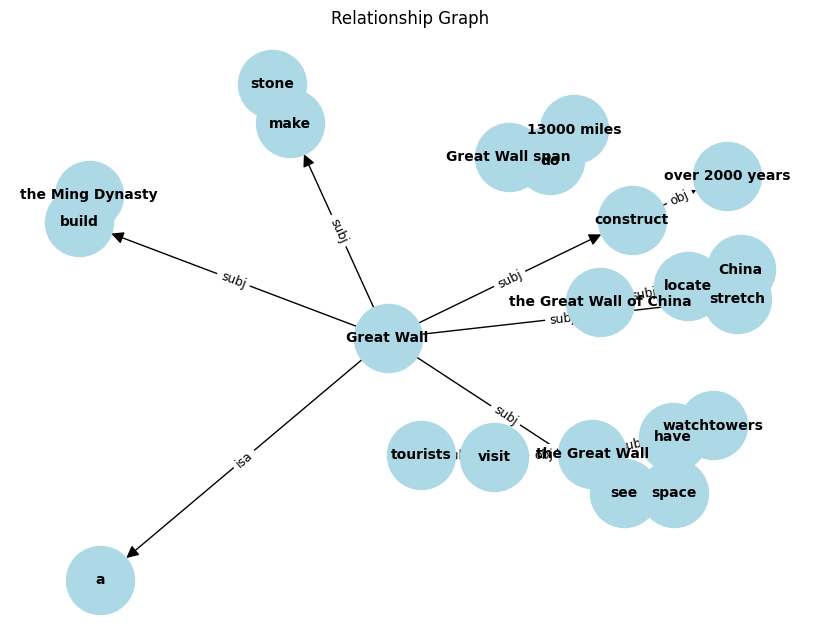

In [3]:
def linearize_relations(relations, max_items=5):
    """Pretty-print first few unified relations, compatible with different schemas."""
    lines = []
    for r in relations[:max_items]:
        # 兼容两种 schema
        head = r.get("head") or r.get("cause") or "?"
        rel = r.get("rel") or r.get("causal_type") or "?"
        tail = r.get("tail") or r.get("effect") or "?"

        attrs = r.get("attrs", {})
        extras = []
        for k in ("strength", "direction", "parser_type"):
            if k in attrs:
                extras.append(f"{k}={attrs[k]}")
        suffix = f"  ({', '.join(extras)})" if extras else ""

        lines.append(f"- {head}  --{rel}-->  {tail}{suffix}")

    return "\n".join(lines) if lines else "(no relations)"


def main(parser_cls):
    """
    Run demo with a parser class that exposes `question_to_graph(question) -> (graph, relations)`
    Returns: combined_graph, all_relations, questions
    """
    questions = [
        "Is the Great Wall of China located in China?",
        "Does the Great Wall span over 13000 miles?", 
        "Was the Great Wall built during the Ming Dynasty?",
        "Can the Great Wall be seen from space?",
        "Is the Great Wall made of stone and brick?",
        "Does the Great Wall have watchtowers?",
        "Was the Great Wall constructed over 2000 years?",
        "Is the Great Wall a UNESCO World Heritage Site?",
        "Does the Great Wall stretch across northern China?",
        "Are millions of tourists visiting the Great Wall annually?"
    ]

    parser = parser_cls()

    combined_graph = nx.DiGraph()
    all_relations = []

    print(f"=== Using parser: {parser_cls.__name__} ===\n")

    for q in questions:
        graph, relations = parser.question_to_graph(q)
        combined_graph = nx.compose(combined_graph, graph)
        all_relations.extend(relations)

        print(q)
        print(linearize_relations(relations, max_items=3))
        print("-" * 70)

    print(f"\nTotal relations extracted: {len(all_relations)}")
    print(f"Combined graph: {combined_graph.number_of_nodes()} nodes, {combined_graph.number_of_edges()} edges")

    # Show a small sample (unified schema)
    print("\nSample Unified Relations:")
    print(linearize_relations(all_relations, max_items=5))

    # Try to visualize with whichever method exists
    vis = getattr(parser, "visualize_graph", None) or getattr(parser, "visualize_causal_graph", None)
    if vis and combined_graph.number_of_nodes() > 0:
        title = "Relationship Graph" if parser_cls.__name__ == "RelationshipGraphParser" else "Combined Causal Graph"
        vis(combined_graph, title)
    else:
        print("No visualization method found or graph is empty.")

    return combined_graph, all_relations, questions

if __name__ == "__main__":
    graph, relations, questions = main(RelationshipGraphParser)
    #graph, relations, questions = main(CausalGraphParser)


## Graph Linerization (to text)

In [4]:
from typing import List, Dict, Optional, Iterable
import networkx as nx
import re

def _sanitize(text: str) -> str:
    """Clean up newlines/multiple spaces to ensure stable vectorization."""
    s = re.sub(r'\s+', ' ', str(text)).strip()
    return s

def _pick_relation(data: Dict) -> str:
    """Pick the relation name from common keys, fallback by priority."""
    for key in ("causal_type", "relation", "label", "type", "rel"):
        if key in data and data[key]:
            return _sanitize(data[key])
    return "related_to"

def linearize_graph(
    G: nx.Graph,
    *,
    undirected_mode: str = "single",  # ["single", "both"]
    default_rel: str = "related_to"
) -> str:
    """
    Serialize any graph (directed/undirected) into multi-line triples, one edge per line:
    Format: HEAD:<u>  REL:<rel>  TAIL:<v>
    - Directed graph: output once along edge direction
    - Undirected graph: single=output once (u,v), both=output in two directions
    """
    lines: List[str] = []

    is_directed = G.is_directed()

    # Choose edge iterator (works for MultiGraph too; with keys=True to preserve multiedges,
    # but here only one relation name is output)
    iterator = G.edges(data=True) if not isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)) \
        else G.edges(keys=True, data=True)

    for e in iterator:
        if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
            u, v, k, data = e
        else:
            u, v, data = e

        u_str = _sanitize(u)
        v_str = _sanitize(v)
        rel = _pick_relation(data) if data else default_rel

        if is_directed:
            lines.append(f"HEAD:{u_str}  REL:{rel}  TAIL:{v_str}")
        else:
            # Undirected graph
            if undirected_mode == "both":
                lines.append(f"HEAD:{u_str}  REL:{rel}  TAIL:{v_str}")
                lines.append(f"HEAD:{v_str}  REL:{rel}  TAIL:{u_str}")
            else:  # "single"
                # Use lexicographic order to avoid duplicates
                h, t = (u_str, v_str) if u_str <= v_str else (v_str, u_str)
                lines.append(f"HEAD:{h}  REL:{rel}  TAIL:{t}")

    # Sort to ensure determinism
    lines = sorted(set(lines))
    return "\n".join(lines)

# Graph representation structure of page content in document
def build_relationship_text(
    question: str,
    G: nx.Graph,
    relations: Optional[List[Dict]] = None,
    *,
    include_question: bool = True,
    include_graph_block: bool = True,
    include_relations_block: bool = True
) -> str:
    """
    Unified construction of text for embedding:
    - [QUESTION] Original question (optional)
    - [GRAPH]    Linearized triples (general, supports any graph)
    - [TRIPLES]  (optional) If relations are provided (e.g., causal extraction result),
                 serialize them as well
    """
    parts: List[str] = []

    if include_question and question:
        #parts.append(f"[QUESTION] {question}")
        pass

    if include_graph_block:
       #parts.append("[GRAPH]")
        #parts.append(linearize_graph(G))
        pass

    if include_relations_block and relations:
        def _one(r: Dict) -> str:
            head = r.get('cause') or r.get('head') or r.get('source') or '?'
            rel  = r.get('causal_type') or r.get('rel') or r.get('relation') or 'related_to'
            tail = r.get('effect') or r.get('tail') or r.get('target') or '?'
            return f"{_sanitize(head)} -> {_sanitize(rel)} -> {_sanitize(tail)}"

        triples_text = "\n".join(_one(r) for r in relations)
        #parts.append("[TRIPLES]")
        parts.append(triples_text)

    return "\n".join(parts)


## Similarity Search

In [5]:
from typing import List, Tuple
from langchain_community.vectorstores import FAISS

# === Basic: Top-k similarity search (with scores) ===
def similarity_search_graph_docs(
    user_question: str,
    parser: CausalGraphParser,
    vectordb: FAISS,
    k: int = 5,
):
    """
    1) Parse the new question into a graph + linearized text (same distribution as stored docs)
    2) Perform similarity search in the vector database, return [(Document, score), ...]
    """
    # Parse the new question into graph & linearized text
    G_new, rels_new = parser.question_to_graph(user_question)
    query_text = build_relationship_text(user_question, G_new, rels_new)
    if query_text:
        print("query_graph_text:", query_text)
        # Search with scores
        results = vectordb.similarity_search_with_score(query_text, k=k)
    else:
        print("Question graph can't be extracted, cannot search")
        results = []
    return query_text, results


# === Optional: MMR search (for more diversity, avoids redundant hits) ===
def mmr_search_graph_docs(
    user_question: str,
    parser: CausalGraphParser,
    vectordb: FAISS,
    k: int = 5,
    fetch_k: int = 20,
    lambda_mult: float = 0.5,
):
    """
    Perform Max Marginal Relevance (MMR) search to improve diversity
    and avoid retrieving highly redundant documents.
    Note: MMR usually returns only documents (no scores). If scores are needed,
    you can re-score the returned documents separately.
    """
    G_new, rels_new = parser.question_to_graph(user_question)
    query_text = build_relationship_text(user_question, G_new, rels_new)
    if query_text:
        print("query_graph_text:", query_text)

        docs = vectordb.max_marginal_relevance_search(
            query=query_text, k=k, fetch_k=fetch_k, lambda_mult=lambda_mult
        )
    else:
        print("Question graph can't be extracted, cannot search")
        docs = []
    return query_text, docs


# === Optional: Threshold filtering (keep only hits above similarity threshold) ===
def similarity_search_with_threshold(
    user_question: str,
    parser: CausalGraphParser,
    vectordb: FAISS,
    k: int = 10,
    score_threshold: float = None,
):
    """
    If you want to filter out low similarity hits, set score_threshold.
    Note: FAISS score meaning depends on implementation
          (sometimes smaller = more similar (L2 distance), sometimes larger = more similar).
          You should print once and check before deciding the threshold strategy.
    """
    query_text, results = similarity_search_graph_docs(user_question, parser, vectordb, k=k)

    if score_threshold is None:
        return query_text, results

    # Assume smaller score = more similar (common for L2 distance).
    # If in your setup larger = better, then change to >= for filtering.
    filtered = [(d, s) for (d, s) in results if s <= score_threshold]
    return query_text, filtered

## RAG workflow

In [10]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document

# Select local embedding model (384 dimensions)
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# --- NEW: LLM (Phi-4-mini-reasoning) + build documents and write answers into metadata ---

from typing import List, Dict, Optional, Tuple
import time
import networkx as nx

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# You already have linearize_graph / build_doc_text
# from your_module import linearize_graph, build_doc_text

# ------------------------------------------------------------
# 0) Load HuggingFace LLM: microsoft/Phi-4-mini-reasoning
# ------------------------------------------------------------
def load_llm_pipeline(
    model_id: str = "microsoft/Phi-4-mini-reasoning",
    device_map: str = "auto",
    dtype: Optional[torch.dtype] = None,
    max_new_tokens: int = 256,
    temperature: float = 0.2,
):
    """
    Return a text-generation pipeline for QA generation.
    """
    if dtype is None:
        # Prefer bfloat16/float16; fallback to float32
        if torch.cuda.is_available():
            dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        else:
            dtype = torch.float32

    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=dtype,
        device_map=device_map,
        trust_remote_code=True,
    )

    gen_pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device_map=device_map,
        torch_dtype=dtype,
        return_full_text=True,   # keep prompt for later truncation
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=0.9,
    )
    return gen_pipe, tokenizer


def answer_with_llm(
    question: str,
    gen_pipe,
    parser,
    faiss_db = None
) -> str:
    retrieved_docs = None
    if faiss_db:
        _, hits = similarity_search_graph_docs(question, parser, faiss_db, k=3)
        retrieved_docs = hits
    
    G, rels = parse_question_to_graph_generic(parser, question) 

    prompt = make_graph_qa_prompt(question, G, rels, retrieved_docs)

    out = gen_pipe(prompt)
    text = out[0]["generated_text"]
    # Cut off the prompt, keep only the model's new output
    answer = text[len(prompt):].strip()
    print(answer)
    return answer

def make_graph_qa_prompt(
    question: str,
    G: nx.Graph,
    relations: Optional[List[Dict]] = None,
    retrieved_docs = None
) -> str:
    #graph_text = linearize_graph(G)
    triples_text = ""
    if relations:
        triples_text = "\n".join(
        f"{u} -> {d.get('rel','related_to')} -> {v}"
        for u, v, d in G.edges(data=True)
    )


    prompt = "You are a precise QA assistant to make current question answer. \n"
        #f"[QUESTION'S GRAPH TRIPLES]\n{graph_text if graph_text.strip() else '__EMPTY_GRAPH__'}\n"
    
    if retrieved_docs:
        prompt += "The system has already search the related question in database and provide its graph triples form and its answer as below.\n"
        related_triples = retrieved_docs[0][0].page_content.strip()
        prompt += f"[RELATED QUESTION'S GRAPH TRIPLES]:\n{related_triples}\n"
        related_answer = retrieved_docs[0][0].metadata["llm_answer"]
        prompt += f"[RELATED QUESTION'S ANSWER]:{related_answer}\n"

    prompt += "Answering the current question concisely and factually in natural language but don't in triples form. If the answer is unknown, say you don't know.\n"\
             f"[CURRENT QUESTION]:{question}\n"
    if triples_text.strip():
        prompt += f"[CURRENT QUESTION'S GRAPH TRIPLES]:\n{triples_text}\n"
    prompt += "[CURRENT QUESTION'S ANSWER]:\n"
    print(prompt)
    return prompt


# ------------------------------------------------------------
# 3) Compatible with different parsers (question_to_graph / question_to_causal_graph)
# ------------------------------------------------------------
def parse_question_to_graph_generic(parser, question: str) -> Tuple[nx.Graph, List[Dict]]:
    """
    Compatible with RelationshipGraphParser.question_to_graph
    and CausalQuestionGraphParser.question_to_causal_graph
    """
    if hasattr(parser, "question_to_graph"):
        return parser.question_to_graph(question)
    elif hasattr(parser, "question_to_causal_graph"):
        return parser.question_to_causal_graph(question)
    else:
        raise AttributeError("Parser must provide question_to_graph or question_to_causal_graph")


# ------------------------------------------------------------
# 4) Build documents (store LLM answer in metadata)
# ------------------------------------------------------------
from langchain.schema import Document

def build_docs_with_answer(
    questions: List[str],
    parser,
    gen_pipe,
    *,
    add_prompt_snapshot: bool = False,
    faiss_db = None
) -> List[Document]:
    docs: List[Document] = []
    for qid, q in enumerate(questions, start=1):
        G, rels = parse_question_to_graph_generic(parser, q)
        text = build_relationship_text(q, G, rels)  # existing function: [QUESTION][GRAPH][TRIPLES]

        # LLM generates answer
        answer = answer_with_llm(q, gen_pipe, parser, faiss_db)

        metadata = {
            "graph_id": f"Q{qid}",
            "question": q,
            "num_nodes": G.number_of_nodes(),
            "num_edges": G.number_of_edges(),
            "llm_model": "microsoft/Phi-4-mini-reasoning",
            "llm_answer": answer,
            "created_at": int(time.time()),
        }
        if add_prompt_snapshot:
            metadata["prompt_snapshot"] = make_graph_qa_prompt(q, G, rels)

        docs.append(Document(page_content=text, metadata=metadata))
    return docs


def build_faiss_index(docs: List[Document]) -> FAISS:
    vectordb = FAISS.from_documents(docs, emb)
    return vectordb


### Answer questions in bulk and load them into the database.

In [7]:
"""
if __name__ == "__main__":
    # 1) Parser
    parser = RelationshipGraphParser()   # or CausalQuestionGraphParser()

    # 2) Load Phi-4-mini-reasoning
    gen_pipe, _ = load_llm_pipeline(
        model_id="microsoft/Phi-4-mini-reasoning",
        device_map="auto",
        dtype=None,                # Automatically select appropriate precision
        max_new_tokens=256,
        temperature=0.2,           # Control randomness
    )

    # 3) Question set
    questions = [
        "Is the Great Wall of China located in China?",
        "Does the Great Wall span over 13000 miles?", 
        "Was the Great Wall built during the Ming Dynasty?",
        "Can the Great Wall be seen from space?",
        "Is the Great Wall made of stone and brick?",
        "Does the Great Wall have watchtowers?",
        "Was the Great Wall constructed over 2000 years?",
        "Is the Great Wall a UNESCO World Heritage Site?",
        "Does the Great Wall stretch across northern China?",
        "Are millions of tourists visiting the Great Wall annually?"
    ]

    # 4) Build documents (including LLM answers in metadata)
    docs = build_docs_with_answer(
        questions, parser, gen_pipe, add_prompt_snapshot=False
    )

    # 5) Vectorization & Save
    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    faiss_db = FAISS.from_documents(docs, emb)
    faiss_db.save_local("graph_rag_faiss_index")
    print(f"FAISS index ready. docs={len(docs)}")"""


    # To load later:
    # faiss_db = FAISS.load_local("graph_rag_faiss_index", emb, allow_dangerous_deserialization=True)


'\nif __name__ == "__main__":\n    # 1) Parser\n    parser = RelationshipGraphParser()   # or CausalQuestionGraphParser()\n\n    # 2) Load Phi-4-mini-reasoning\n    gen_pipe, _ = load_llm_pipeline(\n        model_id="microsoft/Phi-4-mini-reasoning",\n        device_map="auto",\n        dtype=None,                # Automatically select appropriate precision\n        max_new_tokens=256,\n        temperature=0.2,           # Control randomness\n    )\n\n    # 3) Question set\n    questions = [\n        "Is the Great Wall of China located in China?",\n        "Does the Great Wall span over 13000 miles?", \n        "Was the Great Wall built during the Ming Dynasty?",\n        "Can the Great Wall be seen from space?",\n        "Is the Great Wall made of stone and brick?",\n        "Does the Great Wall have watchtowers?",\n        "Was the Great Wall constructed over 2000 years?",\n        "Is the Great Wall a UNESCO World Heritage Site?",\n        "Does the Great Wall stretch across northern

### Test for answering individual questions (adjust prompt with no database context)

In [11]:
if __name__ == "__main__":
    parser = RelationshipGraphParser()   #

    gen_pipe, _ = load_llm_pipeline(
        model_id="microsoft/Phi-4-mini-reasoning",
        device_map="auto",
        dtype=None,                #
        max_new_tokens=256,
        temperature=0.2,
    )

    questions = "Is the Great Wall visible from low Earth orbit?"
    #faiss_db = FAISS.load_local("graph_rag_faiss_index", emb, allow_dangerous_deserialization=True)
    answer = answer_with_llm(questions, gen_pipe, parser)
    #answer = answer_with_llm(questions, gen_pipe, parser, faiss_db)



Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
Device set to use mps


You are a precise QA assistant to make current question answer. 
Answering the current question concisely and factually in natural language but don't in triples form. If the answer is unknown, say you don't know.
[CURRENT QUESTION]:Is the Great Wall visible from low Earth orbit?
[CURRENT QUESTION'S GRAPH TRIPLES]:
Great Wall -> isa -> visible
Great Wall -> property -> visible from low Earth orbit
[CURRENT QUESTION'S ANSWER]:

[{"isHumanMade": false,"isInSpace": false,"isVisibleFromLowEarthOrbit": false}]


In [9]:
"""
# === Helper: Nicely format and print retrieved hits ===
def pretty_print_hits(results: List[Tuple]):
    if not results:
        print("No results.")
        return

    def to_similarity(score: float) -> float:
        # Convert L2 distance into similarity (higher = more similar, range 0~1)
        return 1.0 / (1.0 + score)

    for i, r in enumerate(results, 1):
        if isinstance(r, tuple):  # (Document, score)
            doc, score = r
            sim = to_similarity(score)
            md = doc.metadata
            print(
                f"[{i}] sim={sim:.4f}  (dist={score:.4f})  "
                f"id={md.get('graph_id')}  q={md.get('question')}"
            )
        else:  # MMR returns only Document
            doc = r
            md = doc.metadata
            print(f"[{i}] id={md.get('graph_id')}  q={md.get('question')}")


if __name__ == "__main__":
    parser = RelationshipGraphParser()
    faiss_db = FAISS.load_local("graph_rag_faiss_index", emb, allow_dangerous_deserialization=True)

    user_q = "Is the Great Wall visible from low Earth orbit?"

    print("\n--- Similarity Search (Top-3) ---")
    qtext, hits = similarity_search_graph_docs(user_q, parser, faiss_db, k=3)
    pretty_print_hits(hits)

    print("\n--- MMR Search (Top-3, diverse) ---")
    qtext_mmr, mmr_hits = mmr_search_graph_docs(user_q, parser, faiss_db, k=3, fetch_k=20, lambda_mult=0.5)
    pretty_print_hits(mmr_hits)

    # Optional: apply threshold filtering
    # qtext_thr, hits_thr = similarity_search_with_threshold(user_q, parser, faiss_db, k=10, score_threshold=0.6)
    # pretty_print_hits(hits_thr)"""



'\n# === Helper: Nicely format and print retrieved hits ===\ndef pretty_print_hits(results: List[Tuple]):\n    if not results:\n        print("No results.")\n        return\n\n    def to_similarity(score: float) -> float:\n        # Convert L2 distance into similarity (higher = more similar, range 0~1)\n        return 1.0 / (1.0 + score)\n\n    for i, r in enumerate(results, 1):\n        if isinstance(r, tuple):  # (Document, score)\n            doc, score = r\n            sim = to_similarity(score)\n            md = doc.metadata\n            print(\n                f"[{i}] sim={sim:.4f}  (dist={score:.4f})  "\n                f"id={md.get(\'graph_id\')}  q={md.get(\'question\')}"\n            )\n        else:  # MMR returns only Document\n            doc = r\n            md = doc.metadata\n            print(f"[{i}] id={md.get(\'graph_id\')}  q={md.get(\'question\')}")\n\n\nif __name__ == "__main__":\n    parser = RelationshipGraphParser()\n    faiss_db = FAISS.load_local("graph_rag_fa